## Summary

- write instead of the TS diagram, let's create an overall timeseries of the gateway transport
- this will be as in the proposal and from the notebooks verify_gates_12_15 and wmt_spellout_bigaste
- given that the transport through the gates at one timestep is advection in 3D - flattened and binned - binwidthT or binwidthS
- we can plot the overall contribution to heat/salt over time from the various terms

## goals here:
- GOAL: did the heat contribution from the gates change over time/did the role of the heat contribution change?

In [1]:
# import the packages and functions

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

# the BSO reading is also wrong
choose_UV_bso[20] = "H"
x_bso[x_bso == 161] = 162

# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

In [3]:
# we should redefine gates I think
# start with NaNs (float array so NaN is valid)
gates = np.full((ny, nx), np.nan, dtype=float)

def _paint(x_idx, y_idx, value):
    x = np.asarray(x_idx, dtype=int)
    y = np.asarray(y_idx, dtype=int)
    # keep only points inside the domain
    m = (y >= 0) & (y < ny) & (x >= 0) & (x < nx)
    gates[y[m], x[m]] = value

# 1,2,3,4 for BSO, SFJ, FJNZ, NZRU
_paint(x_bso,  y_bso,  1)
_paint(x_sfj,  y_sfj,  2)
_paint(x_fjnz, y_fjnz, 3)
_paint(x_nzru, y_nzru, 4)

In [4]:
# this is the indices we READ FROM

# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],cmap="Greys",vmin=-2,vmax=4)
# plt.pcolormesh(get_aste_tracer(gates,nfx,nfy)[0])
# plt.ylim(400,550)
# plt.xlim(400,540)

In [5]:
# y_bsoh,x_bsoh,y_bsov,x_bsov,y_fjnzv,x_fjnzv,y_nzruv,x_nzruv,y_spfjh,x_spfjh,y_spfjv,x_spfjv,y_spfjb,x_spfjb

In [6]:
y_bsoh,x_bsoh = np.where(gates==1)[0][:21],np.where(gates==1)[1][:21]
y_bsov,x_bsov = np.where(gates==1)[0][21:],np.where(gates==1)[1][21:]
y_fjnzv,x_fjnzv = np.where(gates==3)[0][:21],np.where(gates==3)[1][:21]
y_nzruv,x_nzruv = np.where(gates==4)[0][:21],np.where(gates==4)[1][:21]

In [7]:
# do spfj -- this is a weird one
a,b = np.where(gates ==2)[0],np.where(gates ==2)[1]

testmsk = np.zeros((ny,nx))
testmsk[a,b] = 1
testmsk[a[:3],b[:3]] = 2
testmsk[a[3],b[3]] = 3  # corner
testmsk[a[7:11],b[7:11]] = 2
testmsk[a[11],b[11]] = 3   # corner
testmsk[a[14:20],b[14:20]] = 2
testmsk[a[20],b[20]] = 3   # corner
testmsk[a[24:28],b[24:28]] = 2
testmsk[a[28],b[28]] = 3   # corner
testmsk[a[33:37],b[33:37]] = 2
testmsk[a[37],b[37]] = 3   # corner
testmsk[a[44:],b[44:]] = 2

testmsk[testmsk==0] = np.nan
# plt.pcolormesh(testmsk)
# plt.xlim(50,100)
# plt.ylim(450,600)

In [8]:
y_spfjh,x_spfjh = np.where(testmsk == 1)[0],np.where(testmsk == 1)[1]
y_spfjv,x_spfjv = np.where(testmsk == 2)[0],np.where(testmsk == 2)[1]
y_spfjb,x_spfjb = np.where(testmsk == 3)[0],np.where(testmsk == 3)[1]

In [9]:
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirdiags = forward_path + "diags/BUDG/"
dirState = forward_path + "diags/STATE/"
dirLayers = layers_path + "diags/LAYERS/"

In [10]:
# load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

In [11]:
# plt.pcolormesh(mymsk)

In [12]:
layers_path

'/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/'

# pause here, I think it would be good to create a program to create layers based on input time step

In [13]:
from create_layers import create_layersTHETA,create_layersSALT

In [14]:
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(5,7,1)
# times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

{'2007': array([5, 6])}


array(['0000280224', '0000284688'], dtype='<U32')

In [15]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [16]:
G_T_offline_new,dF_Tnew = create_layersTHETA(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy)

In [17]:
# check that this is closed:
labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])

s = 0 
for i in range(6):
    at = np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
print("total volume tend LHS: ",np.nansum(dF_Tnew[-1]/dt*1.12643415) / np.nansum(binwidthT1),"m^3/s")

ADVh         217992.86437255502 m^3/s
ADVr         5.5634562402358345e-12 m^3/s
DFh         2520.930232026467 m^3/s
DFr         3.4771601501473963e-12 m^3/s
surf         523629.6595315945 m^3/s
kpp         -1.7385800750736983e-13 m^3/s

total volume tend RHS:  744143.454136176 m^3/s
total volume tend LHS:  800041.2543706949 m^3/s


In [18]:
G_S_offline_new,dF_Snew = create_layersSALT(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy)

In [19]:
# check that this is closed:
labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])

s = 0 
for i in range(6):
    at = np.nansum(dF_Snew[i]) / np.nansum(binwidthS1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
print("total volume tend LHS: ",np.nansum(dF_Snew[-1]/dt*5.2406771) / np.nansum(binwidthS1),"m^3/s")

ADVh         -1803316.103127833 m^3/s
ADVr         1083237.6447774374 m^3/s
DFh         -1317.3554811786933 m^3/s
DFr         3424.618836572831 m^3/s
surf         4380.448890659522 m^3/s
kpp         -1.000938703582148 m^3/s

total volume tend RHS:  -713591.7470430455 m^3/s
total volume tend LHS:  -321614.2765794552 m^3/s


In [20]:
# I think we can move on, just make the same plot in T and S

### create the gateway term in T

In [21]:
# move this into a function in the file

In [22]:
from create_layers import create_gates

In [23]:
G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT, G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = create_gates(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,y_bsoh,x_bsoh,y_bsov,x_bsov,y_fjnzv,x_fjnzv,y_nzruv,x_nzruv,y_spfjh,x_spfjh,y_spfjv,x_spfjv,y_spfjb,x_spfjb)

In [24]:
MsumS = G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS   # overall transport in S
MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT  # overall transport in T

MsumS[np.isnan(MsumS)] = 0
MsumT[np.isnan(MsumT)] = 0

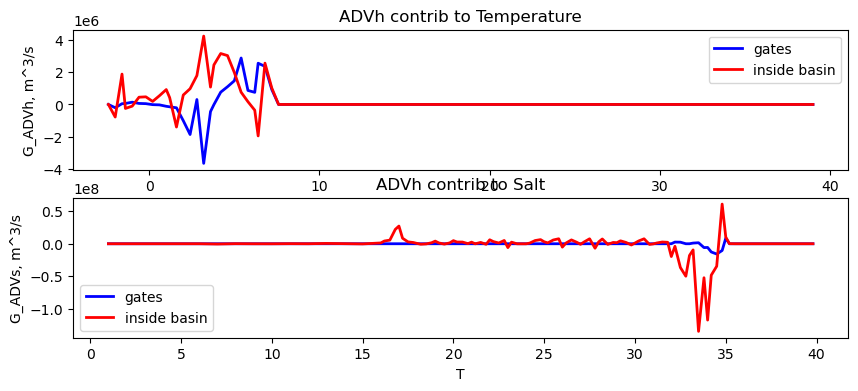

In [25]:
# plot this with T, does this look correct?
fig = plt.figure()

# make sure this is just the Barents Sea -- not verified that that is true

ax = plt.subplot(211)

ax.plot(boundsT.flatten()[1:-1],MsumT,linewidth=2,c="blue",label="gates") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Temperature")

ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],linewidth=2,c="red",label="inside basin") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Temperature")

plt.legend(loc="best")

ax = plt.subplot(212)

ax.plot(boundsS.flatten()[1:-1],MsumS,linewidth=2,c="blue",label="gates") # advh
ax.set_ylabel("G_ADVs, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Salt")

ax.plot(boundsS.flatten()[1:-1],G_S_offline_new[0],linewidth=2,c="red",label="inside basin") # advh
ax.set_ylabel("G_ADVs, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Salt")

plt.legend(loc="best")

In [26]:
print(np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1))
print(np.nansum((G_BSOT + G_FJNZT + G_SPFJT+ G_NZRUT)) / np.nansum(binwidthT1))  # in m^3/s

217992.86437255502
159620.78655901563


In [27]:
# do the same thing for salt
print(np.nansum(dF_Snew[0]) / np.nansum(binwidthS1))
print(np.nansum((G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS)) / np.nansum(binwidthS1))  # in m^3/s

-1803316.103127833
-871297.9470142167


## show budget closure here using the tendency term and the G terms calculated from the file

In [28]:
# we did this before, but can plot here to show again
# we want to summarize the values from the printout before and add these
# let's create a tsstrfull for one year and loop through this to compare

In [29]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(1,13,1)
times['2008'] = np.arange(1,13,1)
print(times)

# the filenames we want for 2014
tsstrfull,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstrfull

{'2007': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), '2008': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}


array(['0000262944', '0000267408', '0000271440', '0000275904',
       '0000280224', '0000284688', '0000289008', '0000293472',
       '0000297936', '0000302256', '0000306720', '0000311040',
       '0000315504', '0000319968', '0000324144', '0000328608',
       '0000332928', '0000337392', '0000341712', '0000346176',
       '0000350640', '0000354960', '0000359424', '0000363744'],
      dtype='<U32')

In [ ]:
labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])  # keep as you had

# how many budget windows (pairs of ts strings)
nt = len(tsstrfull) - 1
nterms = 6

colnames = ["gates"] + list(labels[:nterms]) + ["RHS", "LHS", "residual"]
out_T = np.full((nt, len(colnames)), np.nan, dtype=float)
out_S = np.full((nt, len(colnames)), np.nan, dtype=float)

for it in range(nt):
    print(it)
    tsstr = tsstrfull[it:it+2]
    print(tsstr)

    # calculate the G and M terms
    G_T_offline_new,dF_Tnew = create_layersTHETA(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy)
    G_S_offline_new,dF_Snew = create_layersSALT(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy)
    G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT, G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = create_gates(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,y_bsoh,x_bsoh,y_bsov,x_bsov,y_fjnzv,x_fjnzv,y_nzruv,x_nzruv,y_spfjh,x_spfjh,y_spfjv,x_spfjv,y_spfjb,x_spfjb)

    MsumS = G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS   # overall transport in S
    MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT  # overall transport in T
    MsumS[np.isnan(MsumS)] = 0
    MsumT[np.isnan(MsumT)] = 0

    # write these to a big array
    
    # ---------- THETA ----------
    gates_T = np.nansum(MsumT) / np.nansum(binwidthT1)
    terms_T = np.array([np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1) for i in range(nterms)])
    rhs_T   = np.nansum(terms_T)
    lhs_T   = np.nansum(dF_Tnew[-1]) / np.nansum(binwidthS1)
    res_T   = rhs_T - lhs_T

    out_T[it, :] = np.concatenate(([gates_T], terms_T, [rhs_T, lhs_T, res_T]))

    # ---------- SALT ----------
    gates_S = np.nansum(MsumS) / np.nansum(binwidthT1)
    terms_S = np.array([np.nansum(dF_Snew[i]) / np.nansum(binwidthT1) for i in range(nterms)])
    rhs_S   = np.nansum(terms_S)
    lhs_S   = np.nansum(dF_Snew[-1]) / np.nansum(binwidthS1)
    res_S   = rhs_S - lhs_S

    out_S[it, :] = np.concatenate(([gates_S], terms_S, [rhs_S, lhs_S, res_S]))


0
['0000262944' '0000267408']


In [210]:
# datetimes

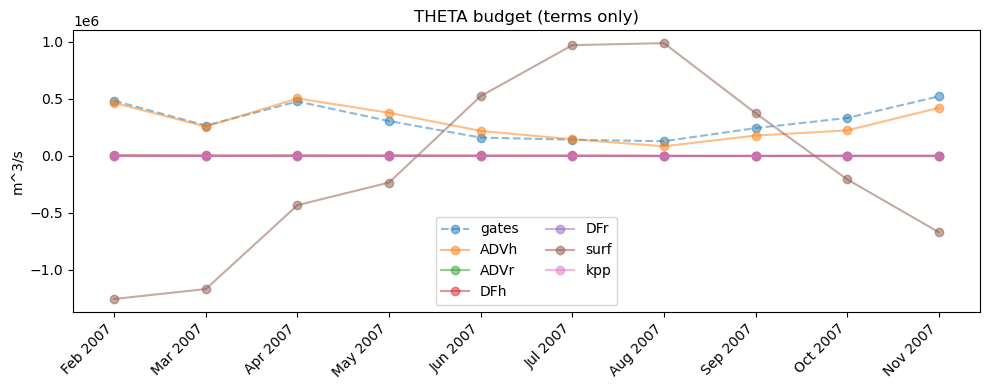

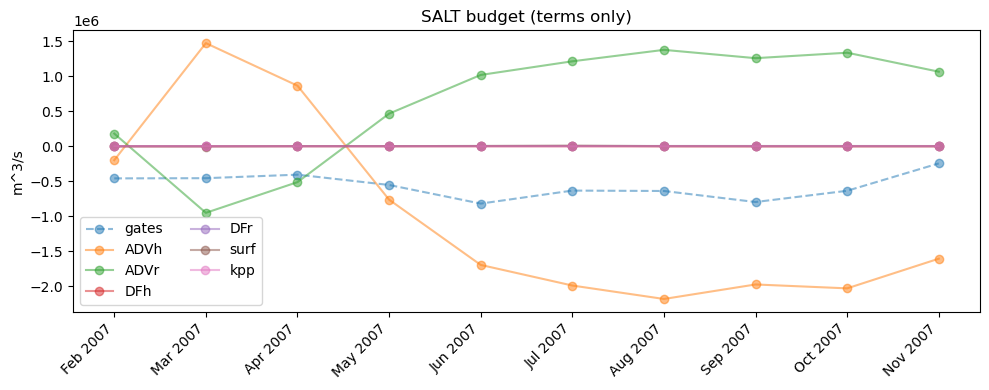

In [193]:
# parse each ts string to "Mon YYYY"
def to_mon_year(s):
    s = str(s)
    for fmt in ("%Y%m%d", "%Y-%m-%d", "%Y%m%d%H", "%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S"):
        try:
            return datetime.strptime(s, fmt).strftime("%b %Y")
        except ValueError:
            pass
    # fallback: try numpy datetime64
    try:
        return np.datetime64(s).astype("datetime64[M]").astype(str)  # "YYYY-MM"
    except Exception:
        return s

xlabels = np.array([to_mon_year(datetimes[i+1]) for i in range(nt)])  # label by window start

x = np.arange(len(xlabels))

def plot_all_terms(out, title):
    plt.figure()

    plot_cols = ["gates"] + list(labels[:nterms])
    plot_idx  = [colnames.index(c) for c in plot_cols]

    special = {"gates"}  # dashed
    for j in plot_idx:
        name = colnames[j]
        ls = "--" if name in special else "-"
        plt.plot(x, out[:, j], linestyle=ls, marker="o", label=name, alpha=0.5)

    plt.xticks(x, xlabels, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("m^3/s")
    plt.legend(ncols=2)
    plt.tight_layout()
    plt.show()

plot_all_terms(out_T, "THETA budget (terms only)")
plot_all_terms(out_S, "SALT budget (terms only)")